In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import glob
import os 
from PIL import Image
import cv2
import torch.nn.functional
import torch.nn as nn 
from torchvision.models import resnet50, ResNet50_Weights


In [2]:
def set_seed(seed:int = 42)-> None:
    """Seed is being set for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42) # Setting the seed so that whenever we try to run the notebook again we get the same results.

In [3]:
class config:
    """Class to set up the configuration parameters"""
    def __init__(self)-> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Defining the paths to the directories
        self.train_image_dir = "/home/moonlab/Reid/data/veri_dataset/image_train"
        self.query__image__dir = "/home/moonlab/Reid/data/veri_dataset/image_query"
        self.gallery__image__dir = "/home/moonlab/Reid/data/veri_dataset/image_gallery"

        # Defining the Model Settings 
        self.clip_model_name="openai/clip-vit-base-patch32"
        self.image_size=(256,256)

        # Defining the Model Parameters
        self.batch_size=32
        self.num_workers=4
        self.learning_rate=3.5e-4
        self.epochs=60
        

        # Defining the dimensions
        self.num_classes=0
        self.feat_dim=2048
        self.clip_dim=512



cfg=config()
cfg.device


        

## Till now we have successfully set up the configuration and seeds.

'cuda'

(np.float64(-0.5), np.float64(1197.5), np.float64(422.5), np.float64(-0.5))

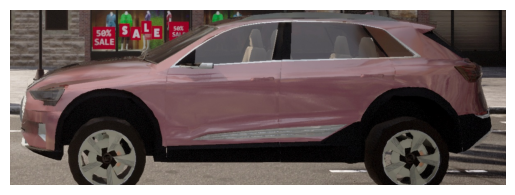

In [4]:
## lets visualize some images from the dataset
image_path1="/home/moonlab/Reid/data/veri_dataset/image_train/20220715035833_26_330.jpg"
image=cv2.imread(image_path1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis("off")



In [5]:
class CarlaVeriDataset(Dataset):
    """This class inherits from the Dataset class of pytorch, hence we will define 
        The required 3 methods __init_, __len__ and __getitem__"""


    """Custom class for loading the Veri Dataset
        The Veri dataset has been taken from the following link:
        <https://github.com/sekilab/VehicleReIdentificationDataset?tab=readme-ov-file>
        @INPROCEEDINGS{10020814,
        author={Kumar, Ashutosh and Kashiyama, Takehiro and Maeda, Hiroya and Zhang, Fan and Omata, Hiroshi and Sekimoto, Yoshihide},
        booktitle={2022 IEEE International Conference on Big Data (Big Data)}, 
        title={Vehicle re-identification and trajectory reconstruction using multiple moving cameras in the CARLA driving simulator}, 
        year={2022},
        volume={},
        number={},
        pages={1858-1865},
        doi={10.1109/BigData55660.2022.10020814}}
        
        
        The dataset that we are using contains synthetic images of vehciles captured in the carla simulator.
        There are 85 camera's starting from 0 to 84 and each vehicle passes through these 85 camera's. """
    
    def __init__(self, dir_path:str, transform=None)->None:
        self.dir_path=dir_path
        self.transform=transform

        # get all the image_paths
        self.image_path=glob.glob(os.path.join(self.dir_path, "*.jpg"))
        self.image_path=sorted(self.image_path)

        if self.image_path is None:
            print("There are no images in the directory.")

        self.pids=[] # This is there to store the vehicle ids
        self.camids=[] # This is there to store the camera ids

        self.valid_paths=[]
        for paths in self.image_path:
            filename=os.path.basename(paths).replace(".jpg","")
            parts=filename.split("_")

            if len(paths)>=3:
                pid=int(parts[1])
                camid=int(parts[2])

                self.pids.append(pid)
                self.camids.append(camid)
                self.valid_paths.append(paths)
        self.image_path=self.valid_paths

        """Note: The PIDS that we have here are not continuous so we have to make sure that they are continous value 
        starting from 0 to num_classes-1, Otherwise our model will collapse during training"""

        self.unique_pids=sorted(list(set(self.pids)))
        self.pid_maps={old:new for new,old in enumerate(self.unique_pids)}
        self.new_pids=[self.pid_maps[p] for p in self.pids]

        print(f"Total images: {len(self.image_path)} Total unique pids: {len(self.unique_pids)}")
        
        
    def __len__(self)-> int:
        return len(self.image_path)
    
    def __getitem__(self, index:int)-> tuple:
        """ This fnction fetches you the image and the corresponding labels"""
        path=self.image_path[index]
        camid=self.camids[index]
        pid=self.new_pids[index]
        original_pid=self.pids[index]

        image=cv2.imread(path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        if self.transform is not None:
            image=self.transform(image)

        return image, pid, camid,original_pid,path
            

        



In [6]:
## lets define the transforms for the dataset
train_transforms=T.Compose([
    T.Resize((256,256)),
    T.RandomHorizontalFlip(),
    T.Pad(10),
    T.RandomCrop(256,256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

## lets execute the verification on the train dataset
train_directory=cfg.train_image_dir
train_dataset=CarlaVeriDataset(dir_path=train_directory, transform=train_transforms)

Total images: 50949 Total unique pids: 85


In [7]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [13]:
class IBN(nn.Module):
    """
    This class implements the Instance-Batch Normalization Layer. 
    NOTE:" Why Instance-Batch Normalization Layer?
    The ResNet that we are implementing here is not the standard ResNet,
    But a modified ResNet with IBN layers.

    Standard ResNet uses Batch Normalization that normalizes the features across the entire batch.
    Instance Normalization normalizes the features for each instance in the batch seperately.


    IN IBN, the feature channels are split into two parts: one part undersgoes Instance Normalization, while the other part goes to the Batch Normalization.
    """

    def __init__(self,planes:int)-> None:
        """In this class we pass the number of feature planes as input"""
        super(IBN,self).__init__()
        half1=int(planes/2)
        half2=planes-half1

        self.IN =nn.InstanceNorm2d(half1,affine=True)
        self.BN=nn.BatchNorm2d(half2)


            
    def foward(self,x:torch.Tensor)-> torch.Tensor:
        """This function defines the forward pass of the IBN Layer"""
        split=torch.split(x, self.half,1)

        out1=self.IN(split[0].contiguous())
        out2=self.BN(split[1].contiguous())


        out=torch.cat((out1,out2),1)
        return out


In [18]:
ibn=IBN(256)
ibn

IBN(
  (IN): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
class BottleneckIBN(nn.Module):
    """This class defines how or convolution layers should be looking but including the Instance Batch Normalization BottleNeck"""
    expansion=4
    def __init__(self, inplanes, planes, strides=1, downsample=None):
        super(BottleneckIBN,self).__init__()

        self.conv1=nn.Conv2d(in_channels=inplanes,out_channels=planes,kernel_size=1,bias=False)
        self.bn1=IBN(planes)

        self.conv2=nn.Conv2d(in_channels=planes, out_channels=planes, padding=1, kernel_size=3, stride=strides, bias=False)
        self.bn2=nn.BatchNorm2d(planes)

        self.conv3=nn.Conv2d(in_channels=planes, out_channels=planes*self.expansion,kernel_size=1, bias=False)
        self.bn3=nn.BatchNorm2d(planes*self.expansion)

        self.relu=nn.ReLU(inplace=True)

        self.downsample=downsample
        self.strides=strides


    def forward(self,x: torch.Tensor)-> torch.Tensor:
        identity=x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)

        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)

        out=self.conv3(out)
        out=self.bn3(out)

        if self.downsample is not None:
            identity=self.downsample(x)

        out+=identity
        out=self.relu(out)

        return out

        

    


In [20]:
class ResNetIBN(torch.nn.Module):
    """In this module we will define the ResNet50 architecture as the feature extractor"""
    def __init__(self,config):
        super(ResNetIBN,self).__init__()
        self.model=resnet50(weights=ResNet50_Weights.DEFAULT)
        layer1_layers=[]

        layer1_layers.append(BottleneckIBN(64,64,strides=1,downsample=self.model.layer1[0].downsample))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))


        self.model.layer1=nn.Sequential(*layer1_layers)
        self.model.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.model.fc=nn.Identity()

        self.model.out_dim=2048


    def forward(self,x):
        features=self.model(x)
        return features
        

        


In [ ]:
class SemanticExtractionModule(nn.Module):
    """
    This class defines the semantic extraction module  using the ClipVector
    Here we input the image tensor and get the CLS token as the semantic vector representation of the image.
    Here the pooler output that we are taking is the CLS token representation of the image. 
    """
    def __init__(self,config):
        super(SemanticExtractionModule,self).__init__()
        self.clip=CLIPModel.from_pretrained(config.clip_model_name)

        self.vision_model=self.clip.vision_model

        for param in self.vision_model.parameters():
            param.requires_grad=False

        self.output_dim=config.clip_dim


    def forward(self,x:torch.Tensor)-> torch.Tensor:
        vision_outputs=self.vision__model(pixel_values=x)
        semantic_features=vision_outputs.pooler_output

        return semantic_features

In [ ]:
# Cell: AFEM Fusion Module
class AFEM(nn.Module):
    def __init__(self, config):
        super(AFEM, self).__init__()
        
        # Dimensions
        self.feat_dim = config.feat_dim   # 2048 (ResNet raw output)
        self.clip_dim = config.clip_dim   # 512 (CLIP output)
        
        # 1. Dimension Reduction Layer
        # Compresses ResNet features (2048) down to match CLIP (512)
        # We use a 1x1 Convolution for this.
        self.dim_reduce = nn.Sequential(
            nn.Conv2d(self.feat_dim, self.clip_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.clip_dim),
            nn.ReLU(inplace=True)
        )
        
        # 2. Attention Network (The "Manager")
        # This takes the CONCATENATED vectors and predicts 2 numbers (weights)
        # Input size = 512 (ResNet) + 512 (CLIP) = 1024
        self.attention_net = nn.Sequential(
            nn.Linear(self.clip_dim * 2, 256), # Compress to 256 hidden neurons
            nn.ReLU(),
            nn.Linear(256, 2), # Output: 2 scores [Weight_App, Weight_Sem]
            nn.Softmax(dim=1)  # Ensure weights sum to 1.0 (e.g., 0.6 + 0.4)
        )
        
        # 3. Final Fusion Layer
        # Takes the weighted sum and projects it back to high dimensions (2048)
        # for the final classification.
        self.fusion_project = nn.Sequential(
            nn.Linear(self.clip_dim, self.feat_dim),
            nn.BatchNorm1d(self.feat_dim),
            nn.ReLU()
        )

    def forward(self, f_app, f_sem):
        """
        f_app: From ResNet [Batch, 2048, 1, 1]
        f_sem: From CLIP   [Batch, 512]
        """
        
        # Step A: Align Dimensions
        # Squeeze ResNet: [Batch, 2048, 1, 1] -> [Batch, 512, 1, 1]
        x_app = self.dim_reduce(f_app)
        # Flatten: [Batch, 512]
        x_app = x_app.view(x_app.size(0), -1)
        
        # Step B: CONCATENATION (Here is the moment!)
        # We join them side-by-side to let the attention network compare them.
        # Shape becomes: [Batch, 1024]
        combined = torch.cat((x_app, f_sem), dim=1)
        
        # Step C: Calculate Attention Weights
        # "How important is Appearance? How important is Semantic?"
        weights = self.attention_net(combined) # Output: [Batch, 2]
        
        w_app = weights[:, 0].unsqueeze(1) # Weight for Appearance
        w_sem = weights[:, 1].unsqueeze(1) # Weight for Semantic
        
        # Step D: Weighted Fusion
        # The Final Vector = (Weight1 * App) + (Weight2 * Sem)
        fused_vector = (w_app * x_app) + (w_sem * f_sem)
        
        # Step E: Restore to High Dimension (2048)
        out = self.fusion_project(fused_vector)
        
        return out, weights # Return weights for plotting!

In [ ]:
# Cell: Semantic Extraction Module (CLIP)
import torch
import torch.nn as nn
from transformers import CLIPModel

class SemanticExtractionModule(nn.Module):
    def __init__(self, config):
        super(SemanticExtractionModule, self).__init__()
        
        print(f"🧠 Loading CLIP Semantic Branch: {config.clip_model_name}...")
        
        # 1. Load the Full CLIP Model
        # This downloads the weights from Hugging Face (OpenAI's original weights)
        self.clip = CLIPModel.from_pretrained(config.clip_model_name)
        
        # 2. Extract ONLY the Vision Transformer (ViT)
        # CLIP has two heads: Text and Vision. We only need the eyes.
        self.vision_model = self.clip.vision_model
        
        # 3. Freeze the Parameters (The "Do Not Touch" Sign)
        # CLIP was trained on 400 Million images. Our dataset is tiny (40k).
        # If we try to train CLIP, we will "break" its brain (Catastrophic Forgetting).
        # We assume CLIP is already smart enough.
        for param in self.vision_model.parameters():
            param.requires_grad = False
            
        # 4. Set Output Dimension
        # CLIP ViT-Base always outputs a 512 vector
        self.output_dim = config.clip_dim 

    def forward(self, x):
        """
        Input: Batch of Images [Batch, 3, 256, 256]
        Output: Semantic Feature Vector [Batch, 512]
        """
        
        # CLIP expects the argument name 'pixel_values'
        outputs = self.vision_model(pixel_values=x)
        
        # 5. Get the "Pooler Output"
        # The Vision Transformer produces a sequence of vectors (one for each patch of the image).
        # It also produces one special vector called the 'pooler_output' (or CLS token).
        # This single vector summarizes the ENTIRE image concept.
        semantic_features = outputs.pooler_output
        
        return semantic_features

# --- VERIFICATION BLOCK ---
if __name__ == "__main__":
    # Test on Dummy Data
    print("Testing Semantic Module...")
    
    # 1. Create Module
    sem_module = SemanticExtractionModule(config).to(config.device)
    
    # 2. Create Dummy Batch (4 images, 3 channels, 256x256)
    dummy_img = torch.randn(4, 3, 256, 256).to(config.device)
    
    # 3. Run Forward Pass
    out = sem_module(dummy_img)
    
    print(f"Input Shape:  {dummy_img.shape}")
    print(f"Output Shape: {out.shape}") 
    # Expected: [4, 512]

# Test the construction
if __name__ == "__main__":
    backbone = ResNetIBN(config).to(config.device)
    
    # Dummy Input (Batch 2, 3 Channels, 256x256)
    dummy_input = torch.randn(2, 3, 256, 256).to(config.device)
    
    # Run Forward
    output = backbone(dummy_input)
    
    print(f"\n✅ Output Shape: {output.shape}")
    # Expected: [2, 2048]